# Data Exploration

All the data is contained in a json file. My guess is that each 75x75 image is just encoded as a set of numbers. Importantly, each of these numbers is not from 0-255 like a regular image, they each measure of signal intensity in dB.  In addition to the image file there are a number of other features included in the data that I'll explore now.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import collections as cs
%matplotlib inline

Set up the paths to the data I'm using, for right now I'll ignore creating training, validation, and sample data sets since I want to look at the features of all the training data. Before making any submissions I should also compare my training data to the test data to see if there are any differences http://onlinelibrary.wiley.com/doi/10.1029/97JC01615/abstract

In [2]:
path = os.curdir + '/data/processed/'
train_json = path + 'train.json'

Let's read in the json data with pandas

In [3]:
train = pd.read_json(train_json)
train = train.replace(to_replace='na', value=np.nan)

In [4]:
len(train.band_2.iloc[1])

5625

It looks like we have 1604 images in the training set. Band_1 is the intensity at the detector of horizontal polarized radiation and Band_2 is for vertically polarized radiation. The polarization angles could be very helpful for identifying ice. Aside from these two columns, there is the id, the incident angle, and target (is_iceberg).

The incident angle has some null values that are obnoxious just called na instead of being numpy NA, so let's fix that (moved above to avoid confusion).

I'll start by separating the data on whether it represents an iceberg or not, and then I can compare the two groups

In [5]:
iceberg = np.where(train.is_iceberg==1)[0]
not_iceberg = np.where(train.is_iceberg==0)[0]

## Is_iceberg Counts

(array([ 851.,    0.,  753.]),
 array([ 0.        ,  0.33333333,  0.66666667,  1.        ]),
 <a list of 3 Patch objects>)

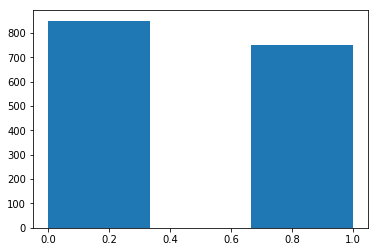

In [6]:
plt.hist(train.is_iceberg, bins=3)

In [7]:
cs.Counter(train.is_iceberg)

Counter({0: 851, 1: 753})

It looks like the classes are well balanced

## Incident Angle

My guess is that the range of angles will be from between +45 and -45, but let's find out.

In [8]:
max(train.inc_angle)

45.9375

In [9]:
min(train.inc_angle)

24.7546

Alright, none of these have negative angles, wouldn't really be necessary since positive and negative are the same for this kind of data. Interesting that the incident angle has such a high range. I would expect image with a higher incident angle to possibly have larger object sizes and more distortion (depends on how data was processed and on the height to base area ratio of the objects, icebergs are probably taller than ships).

I would be interested to see if the incidence angle has any effect on the polarization, my guess is that it should, but I need to read some literature about the spectroscopy of sea ice.

In [10]:
is_null = np.where(train.inc_angle.isnull()==True)[0]
train_inc_angle = train.drop(is_null, axis=0)

In [11]:
train_inc_angle.inc_angle.mean()

39.26870747790618

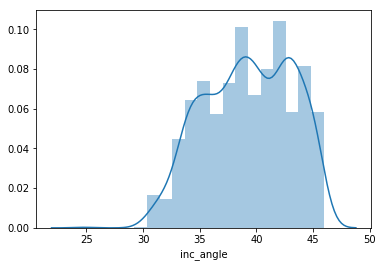

In [12]:
sns.distplot(train_inc_angle.inc_angle)

Looks like the distribution is roughly normal, let's check a histogram

(array([   1.,    0.,   52.,  239.,  235.,  358.,  339.,  247.]),
 array([ 24.7546   ,  27.4024625,  30.050325 ,  32.6981875,  35.34605  ,
         37.9939125,  40.641775 ,  43.2896375,  45.9375   ]),
 <a list of 8 Patch objects>)

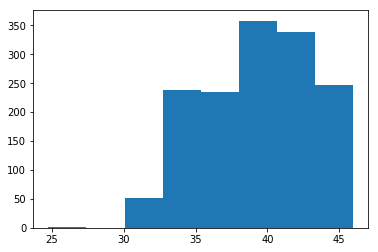

In [13]:
plt.hist(train_inc_angle.inc_angle, bins=8)

Definitely skewed to the higher end of 35 to 40 degrees. Let's see if class makes any difference. Need to separate out all the null values

In [14]:
inc_iceberg = np.where(train_inc_angle.is_iceberg==1)[0]
inc_not_iceberg = np.where(train_inc_angle.is_iceberg==0)[0]

In [15]:
inc_angle_iceberg = np.array(train_inc_angle.iloc[inc_iceberg, :].inc_angle)
inc_angle_not_iceberg = np.array(train_inc_angle.iloc[inc_not_iceberg, :].inc_angle)

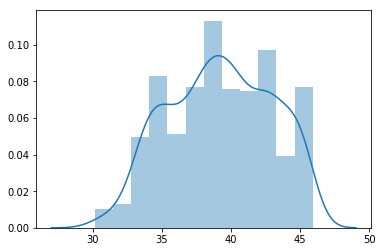

In [16]:
sns.distplot([inc_angle_iceberg])

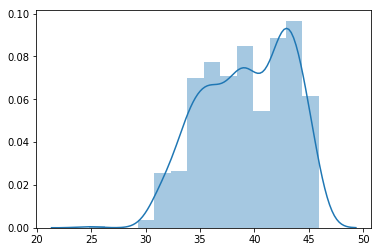

In [17]:
sns.distplot([inc_angle_not_iceberg])

In general, it looks like the distributions are about the same, so the incident angle by itself doesn't seem to say anything about whether it's an iceberg or not. Let's check correlation though

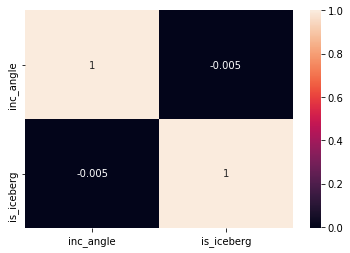

In [18]:
sns.heatmap(train_inc_angle.corr(), annot=True)

No correlation at all

## Band_1

I'm curious to see how large of a range of dB we're dealing with, would it be possible to rescale the data to match the image standard of 0-255, then maybe use VGG or some other pretrained CNN?

In [19]:
band_1_flat = np.concatenate(train.band_1, axis=0)

In [20]:
max(band_1_flat)

34.574916999999999

In [21]:
min(band_1_flat)

-45.594448

I think negative decibels means that the reflected signal has less power than the incident signal and positive means that it has more power.

http://www.animations.physics.unsw.edu.au/jw/dB.htm

Let's see what the overall distribution looks like.

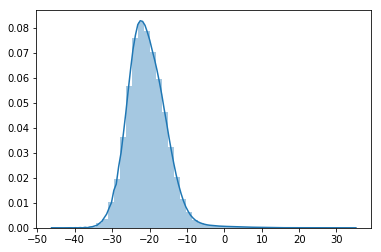

In [22]:
sns.distplot(band_1_flat)

So we're looking at measured signals that are generally quite a bit smaller than the emitted signal.

In [23]:
10**(-2)

0.01

In [24]:
def band_to_image(band):
    x = np.reshape(band, (75,75))
    return x

In fact it looks like the average signal is 1/100th the intensity. Let's see what individual images look like.

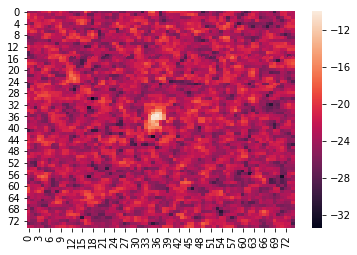

In [26]:
sns.heatmap(band_to_image(train.band_1.iloc[2]))

Right off the bat it looks like the range of decibels is random, maybe based on imaging conditions, sea temperature, salinity, altitude, incidence angle, etc. Honestly, don't know yet, but intensity by itself doesn't seem like it matters very much.

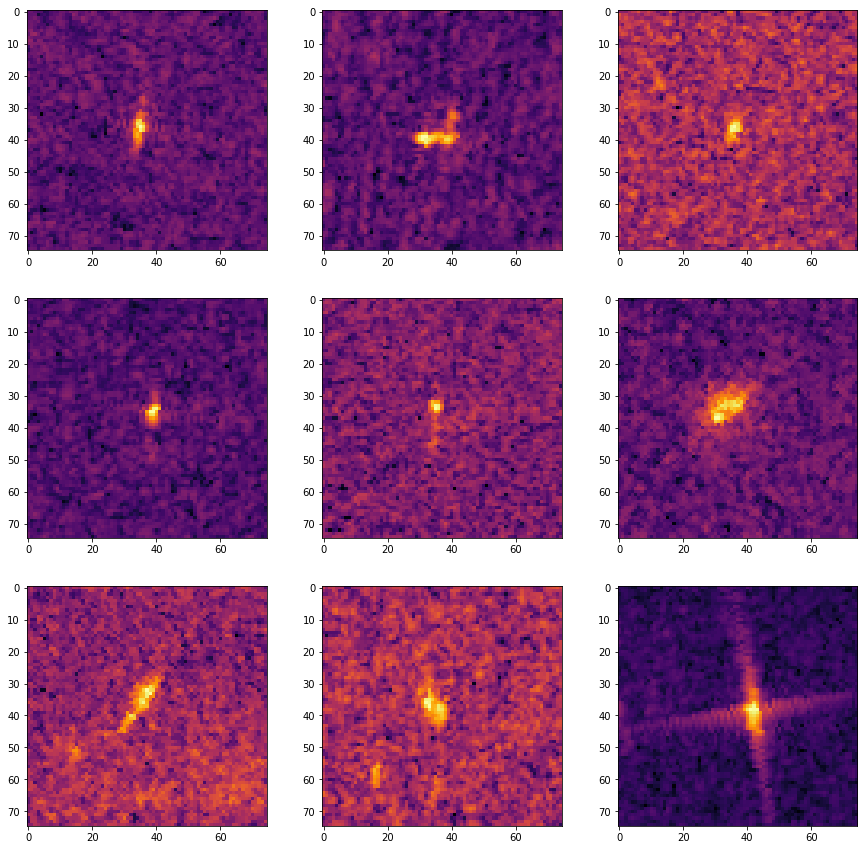

In [27]:
# Plot band_1
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = band_to_image(train.band_1[i])
    ax.imshow(arr,cmap='inferno')
    
plt.show()

I'll use this helpful little function from https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python to get some variables that might be interesting, and to see how incident angle affects the average intensity of the image.

In [28]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train

train_stats = get_stats(train_inc_angle,1)

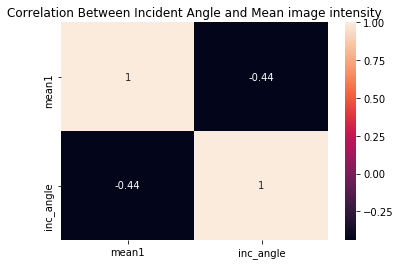

In [29]:
plt.title('Correlation Between Incident Angle and Mean image intensity')
sns.heatmap(pd.concat([train_stats.mean1, train_stats.inc_angle], axis=1).corr(), annot=True)

Clearly there is some correlation which makes sense to me. I think there might also be some kind of relationship between horizontal and vertical intensity and incident angle. Next, I want to see how the pixel intensities line up

Now I'm going to plot the images in band_1 with the lowest standard deviation, in theory I think these should be the images with the least distinct features

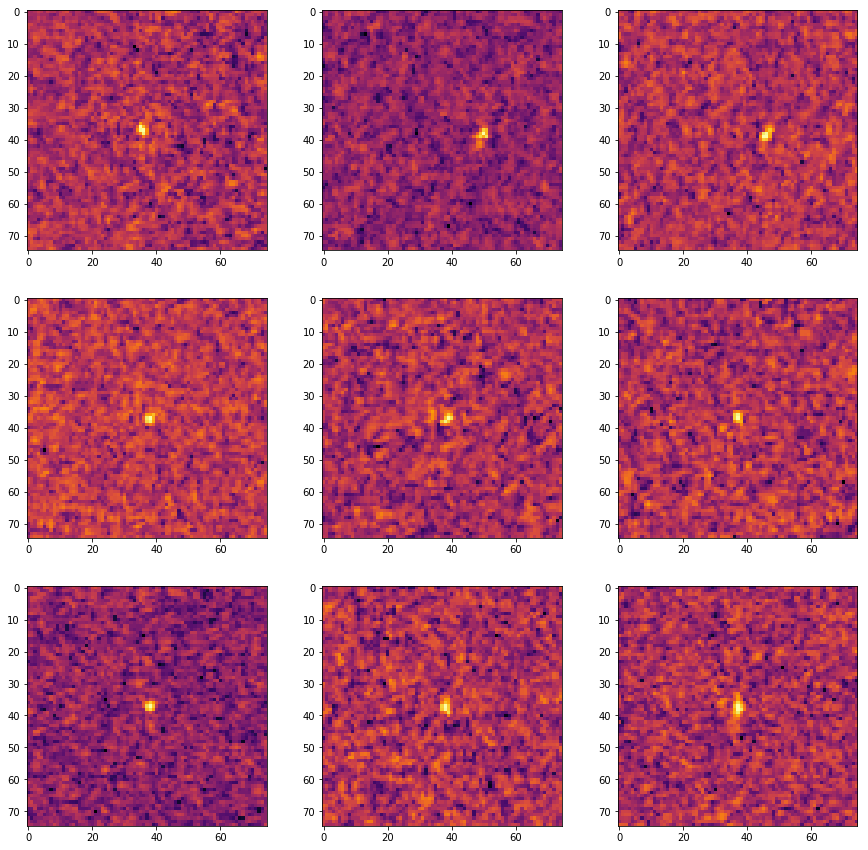

In [30]:
# Plot band_1
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = band_to_image(train.band_1[train_stats.sort_values(by='std1').index[i]])
    ax.imshow(arr,cmap='inferno')
    
plt.show()

Some of these images have almost no discernable features, I agree with other analysis that I've read though, there does seem to be some pattern to the noise. It doesn't seem like a small convolution window would turn up much information because neighboring pixels don't seem to be related. Could try 7x7 or 11x11 convolutions. Need to figure out how to detect and remove the noisy background pattern.

## Band_2

This is really just a copy of the analysis I did in band_1

In [31]:
band_2_flat = np.concatenate(train.band_2, axis=0)

In [32]:
max(band_2_flat)

20.154249

In [33]:
min(band_2_flat)

-45.655498999999999

Clearly a difference in the max value of about 10dB (which is 10 times less). Let's check the distribution

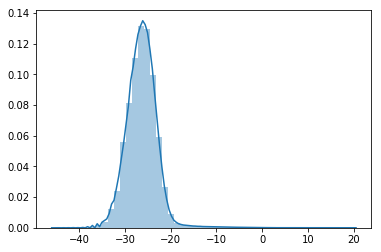

In [34]:
sns.distplot(band_2_flat)

Still pretty much the same distribution as band_1

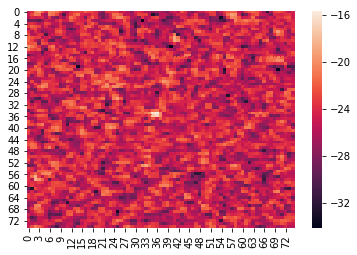

In [35]:
sns.heatmap(band_to_image(train.band_2.iloc[2]))

Right off the bat it looks like the range of decibels is random, maybe based on imaging conditions, sea temperature, salinity, altitude, incidence angle, etc. Honestly, don't know yet, but intensity by itself doesn't seem like it matters very much.

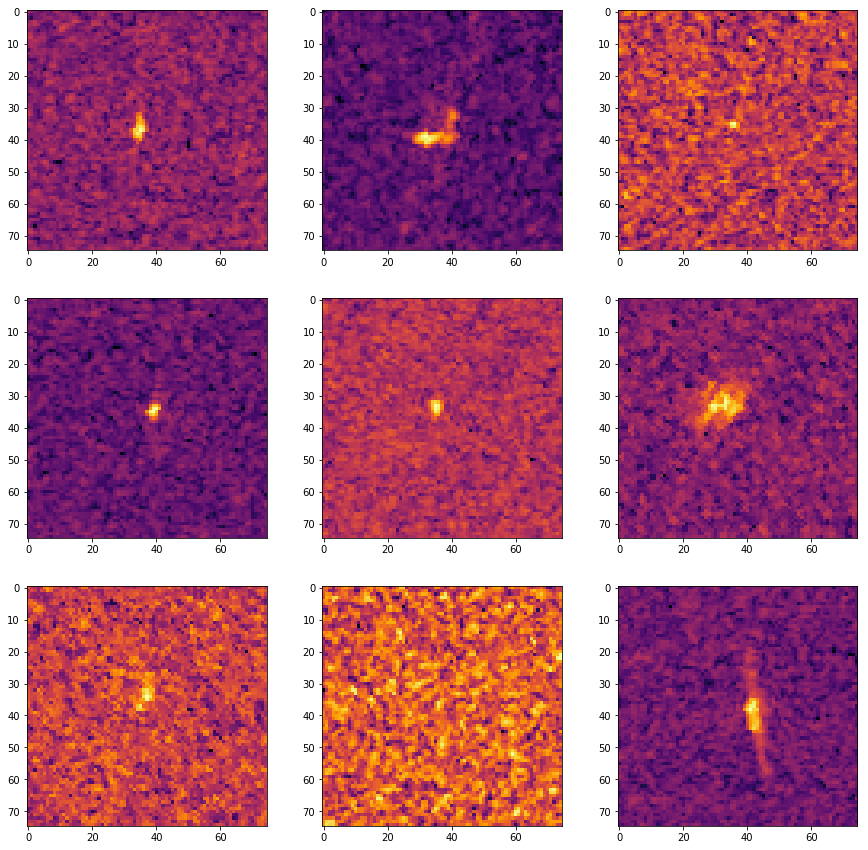

In [36]:
# Plot band_1
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = band_to_image(train.band_2[i])
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [37]:
train_stats_2 = get_stats(train_inc_angle, 2)

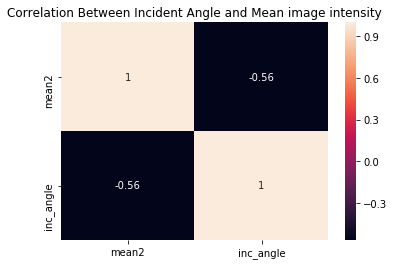

In [38]:
plt.title('Correlation Between Incident Angle and Mean image intensity')
sns.heatmap(pd.concat([train_stats_2.mean2, train_stats_2.inc_angle], axis=1).corr(), annot=True)

Clearly there is some correlation which makes sense to me. I think there might also be some kind of relationship between horizontal and vertical intensity and incident angle. Next, I want to see how the pixel intensities line up

Now I'm going to plot the images in band_2 with the lowest standard deviation, in theory I think these should be the images with the least distinct features

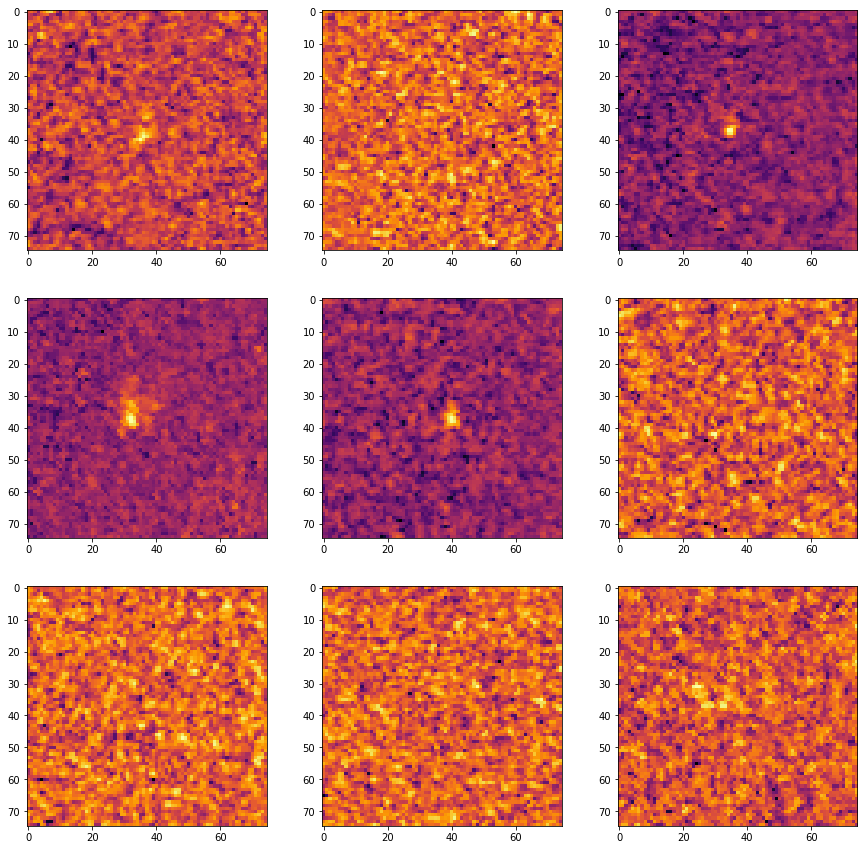

In [39]:
# Plot band_2
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = band_to_image(train.band_2[train_stats_2.sort_values(by='std2').index[i]])
    ax.imshow(arr,cmap='inferno')
    
plt.show()

## Combining Band 1 and Band 2

I don't think that it makes sense to worry about optimizing band_1 or band_2, because ultimately the two bands need to be combined to create the best image. The signal should be in roughly the same area on both band_1 and band_2 whereas the background might not have any correlation. Let's see if there is a correlation between individual points in each of the bands.

The background intensity is confirmed to be somewhat random based on wind conditions and the incident angle. In general, the water background has higher intensity when the signal is roughly normal. So it definitely seems like the incident angle could be a useful correction in preprocessing rather than a feature worth training the network on.

The first thing that I want to see is how band_1 and band_2 are correlated. As a sample I'll look at max, min, and median value correlations. 

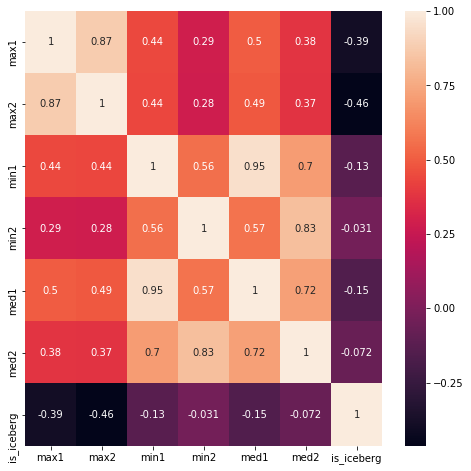

In [40]:
plt.figure(figsize=(8,8))
max_min_med = pd.concat([train_stats.max1, train_stats.max2, train_stats.min1,
                              train_stats.min2, train_stats.med1, train_stats.med2, train_stats.is_iceberg], axis=1)
sns.heatmap(max_min_med.corr(), annot=True)

Makes good sense, the maximums are positively correlated which means that there probably isn't some kind of inverse relationship like I originally thought. The min values are probably just points somewhere in the background noise, so it's not surprising that they wouldn't be very well correlated. The medians are correlated at a level pretty close to the median between the max and min correlations.

I'm curious to see if the mean of the two bands looks good or not, since it seems like everyone on kaggle is doing that

In [41]:
high_stdev_bands = train_stats_2.sort_values(by='std2').index

In [42]:
high_stdev_bands

Int64Index([ 910,  801,  222,  845, 1312, 1439,  940,  992,  405,  203,
            ...
            1469, 1359, 1119,  566,  194,  351,  385,  739,  844, 1350],
           dtype='int64', length=1471)

In [43]:
band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train_inc_angle.band_1])
band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train_inc_angle.band_2])
mean_band = (0.5*(band_1+band_2))

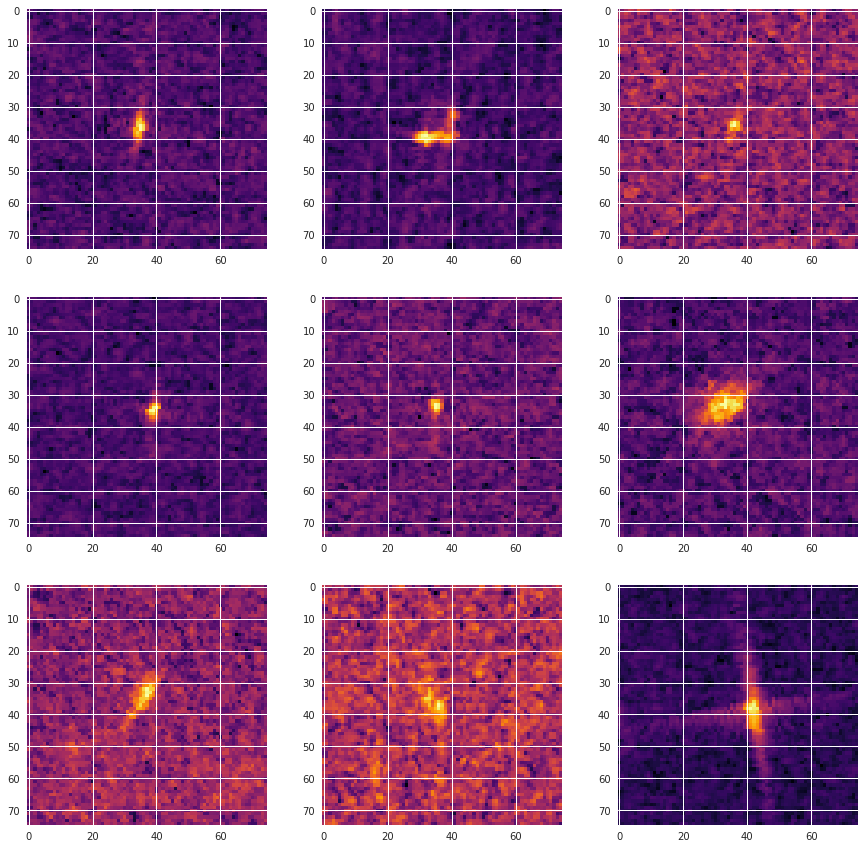

In [44]:
# Plot bands' mean
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = mean_band[i]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

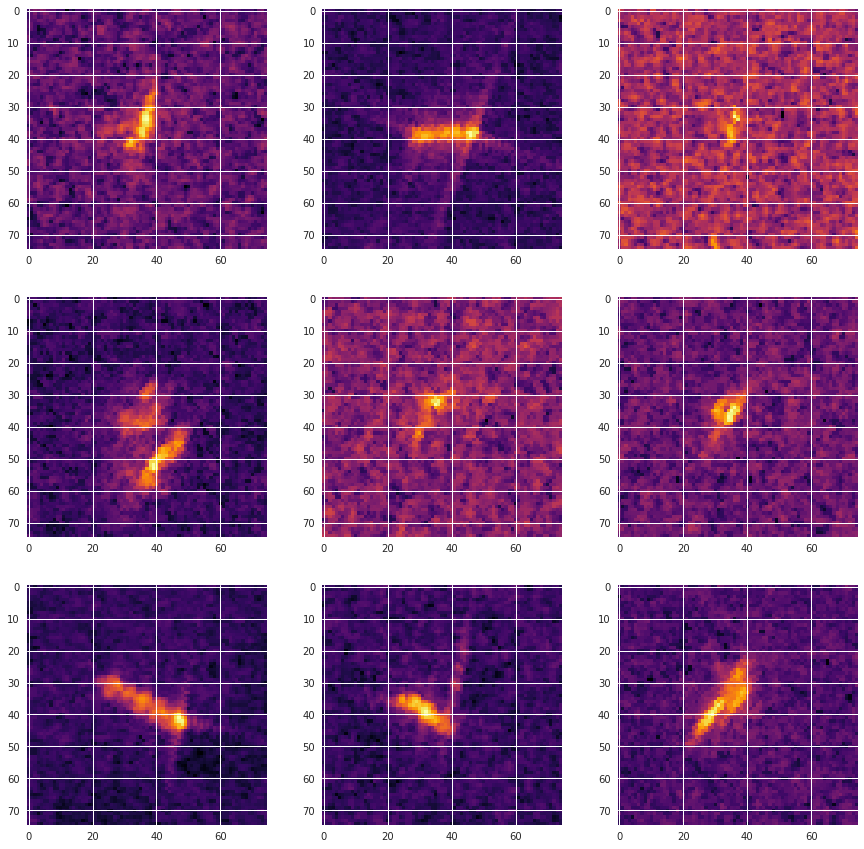

In [45]:
# Plot highest stdev bands in band_2
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = mean_band[high_stdev_bands[i]]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

This clearly looks better than the very noisy images previously seen in band_2. I'm still skeptical that it's the best method, but from this, it seems hard to argue that it's pretty good.

In [46]:
mean_bands_stdev = np.array([band.std() for band in mean_band])

In [47]:
high_stdev_mean_bands = np.argsort(mean_bands_stdev)

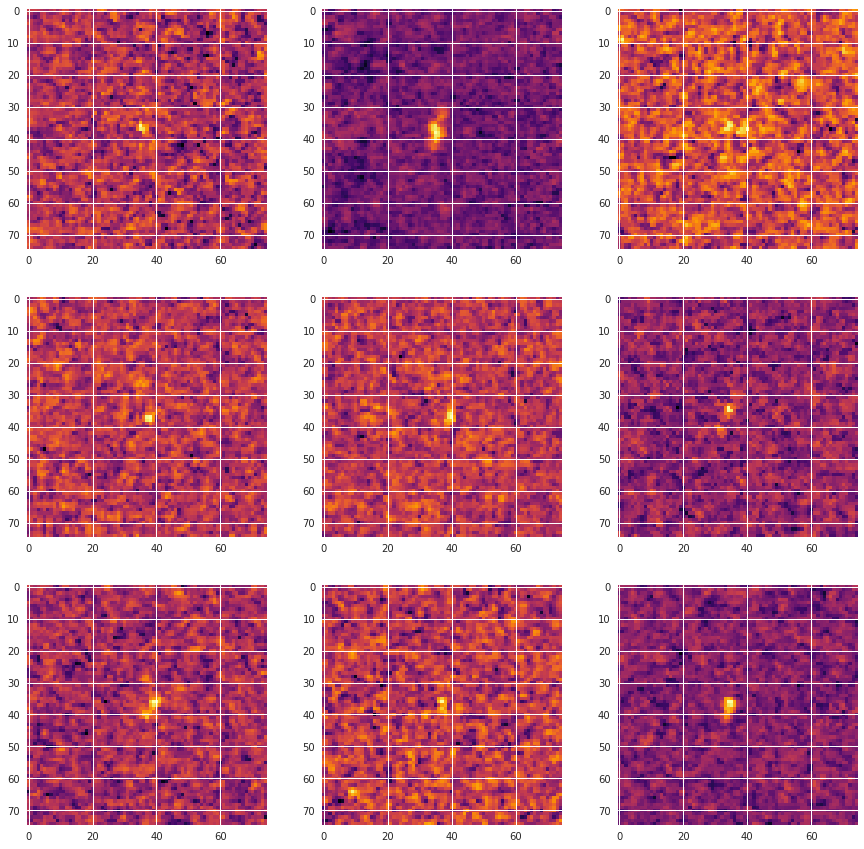

In [48]:
# Plot highest stdev bands in mean_band
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = mean_band[high_stdev_mean_bands[i]]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

The worst averaged bands still have some serious issues, but all at least have some perceivable shape, which is a step up from the individual bands.

Next, I want to try normalizing the averaged bands (i.e. subtract average and divide by standard deviation)

In [49]:
def normalize_band(band):
    normed = []
    img_mean = np.array([np.mean(img) for img in band])
    img_std = np.array([np.std(img) for img in band])
    normed = np.array([(image-img_mean[i])/img_std[i] for i,image in zip(range(len(band)), band)])
    return normed

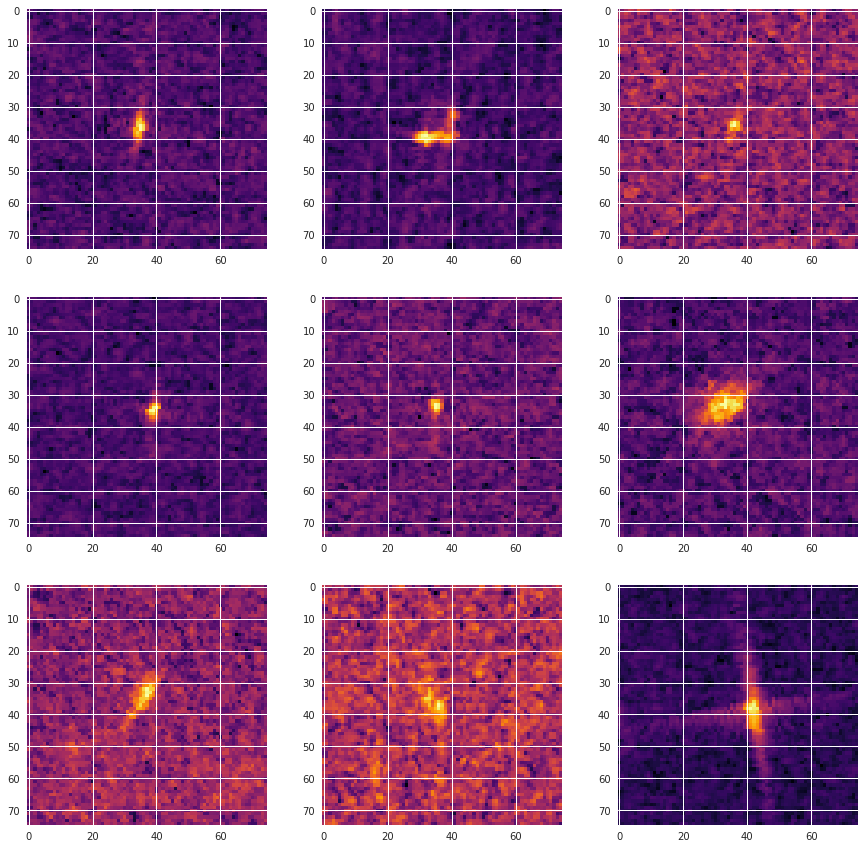

In [50]:
# Plot normalized images
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = normalize_band(mean_band)[i]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

I guess that doesn't really do anything...

I also want to consider the possibility of Brewster's angle and read more about SAR polarimetry. For right now, I'll stick with the mean band, but I think there is probably a better way to combine the two layers. Before I spend all my time here, though, I need to move on and explore other features of the data. However, my CNN's accuracy is bad, this is the first place I'll start. Another idea that occurs to be is to create a massive "hyperspectral" image. Just stack a bunch of random combination layers together to form an image with many channels.

That might actually be a good idea. It doesn't make sense to kill myself figuring out how to combine the HH and HV layers, let a model do it for you. In theory, the first part of your CNN could essentially be a full sized convolution with two inputs, it would create combinations of the two layers to feed into the network. Just like the convolution layers undergo backprop, you could apply backprop to the combined layers.

I think this could work, but I have no idea how to program it!

## Combining Bands and Incident Angle

Before diving into some transforms for the averaged data, I want to see how well the incident angle works at a correction. In particular, I want to see if it helps to reduce the background water noise.

I'm mostly concerned with filling in the NA values. I know that the background values are correlated with incident angle, so I'll try that.

In [61]:
inc_min = pd.DataFrame([(train_inc_angle.min2), train_inc_angle.inc_angle]).T

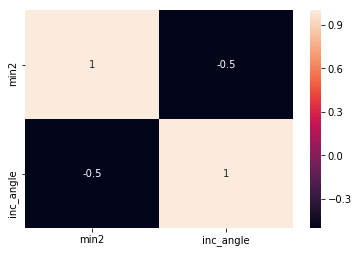

In [62]:
sns.heatmap(inc_min.corr(), annot=True)

In [63]:
from scipy.stats import linregress

In [64]:
linregress(train_inc_angle.min2, train_inc_angle.inc_angle)

LinregressResult(slope=-0.80926200397895132, intercept=9.3460257880883049, rvalue=-0.50142649599047762, pvalue=1.7442572879351215e-94, stderr=0.03643238549297214)

In [79]:
train = pd.read_json(train_json)

In [84]:
len(train.band_2.max())

5625

In [ ]:
train = train.replace(to_replace='na', value=())

## Transformations

I've seen others try to transform the images to eliminate noise. I doesn't make a lot of sense to do this because the CNN will already apply filters to the raw images and optimize them by SGD and backprop until the best filters for "seeing" the image are developed. If the best filters is say a Gaussian blur, then the CNN should converge on that filter if I train it long enough. The only kinds of transforms that might matter are ones that aren't just 3x3 filters, or if I decide to create a tree model then maybe I would apply a transform before gathering image statistics.